# Robustness

- [Training Dataset](https://huggingface.co/datasets/uoft-cs/cifar10)
- [Corrupt Dataset](https://huggingface.co/datasets/robro/cifar10-c-parquet)

---

- [1] D. Hendrycks and T. Dietterich, “Benchmarking Neural Network Robustness to Common Corruptions and Perturbations,” Mar. 28, 2019, arXiv: arXiv:1903.12261. doi: 10.48550/arXiv.1903.12261.
- [1] K. He, X. Zhang, S. Ren, and J. Sun, “Deep Residual Learning for Image Recognition,” Dec. 10, 2015, arXiv: arXiv:1512.03385. doi: 10.48550/arXiv.1512.03385.

---

- Original Dataset Website [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)
- https://debuggercafe.com/building-resnets-from-scratch-using-pytorch/
- https://towardsdev.com/implement-resnet-with-pytorch-a9fb40a77448

## Pip Installs

In [1]:
%pip install torch torchvision matplotlib numpy scikit-learn tqdm pandas datasets torchinfo

Note: you may need to restart the kernel to use updated packages.


## Global Imports

In [2]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else
                      "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Device: {device}")

Device: mps


## Load CIFAR10 and CIFAR10-C Datasets

In [4]:
from datasets import load_dataset

t_dataset = load_dataset("cifar10", trust_remote_code=False)
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck",]

c_dataset = load_dataset("robro/cifar10-c-parquet", trust_remote_code=False)
corruptions = ['brightness', 'contrast', 'defocus_blur', 'elastic_transform',
    'fog', 'frost', 'gaussian_blur', 'gaussian_noise', 'glass_blur',
    'impulse_noise', 'jpeg_compression', 'motion_blur', 'pixelate',
    'saturate', 'shot_noise', 'snow', 'spatter', 'speckle_noise',
    'zoom_blur']

display(t_dataset)
display(c_dataset)


DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'corruption_name', 'corruption_level'],
        num_rows: 950000
    })
})

## Mean and Std of the Datasets

Here we are double checking the internent's common values for the training dataset for Mean and Standard Devation for the training and robustness dataset. We are getting slighly diffrent values, but decided to use the values found on the internet instead.


In [6]:
if False:
    import torch
    import io
    import torchvision.transforms as transforms

    def make_tensor_map(col: str):
        def pil_to_tensor(row):
            if isinstance(row[col], dict) and "bytes" in row[col]:
                img = Image.open(io.BytesIO(row[col]["bytes"]))
            elif isinstance(row[col], bytes):
                img = Image.open(io.BytesIO(row[col]))
            else:
                img = row[col]
            row["pixel_values"] = transforms.ToTensor()(img)
            return row
        return pil_to_tensor

    def calculate_mean_std(dataset):
        # Stack all the tensors in the dataset into a single 4D tensor of shape (num_images, 3, 32, 32).
        pixel_values = [torch.tensor(example["pixel_values"]) for example in dataset]
        all_images = torch.stack(pixel_values)
        # Calculate mean and std for each channel (R, G, B)
        mean = all_images.mean(dim=[0, 2, 3])  # batch, height, width
        std = all_images.std(dim=[0, 2, 3])
        return mean, std

    t_dataset = t_dataset["train"].map(make_tensor_map("img"))
    c_dataset = c_dataset["train"].map(make_tensor_map("image"))
    # display(t_dataset.to_pandas())
    t_mean, t_std = calculate_mean_std(t_dataset)
    c_mean, c_std = calculate_mean_std(c_dataset)

    print(f"Mean: {t_mean} Std: {t_std}")
    print(f"Mean: {c_mean} Std: {c_std}")

    # Output
    # Mean: tensor([0.4914, 0.4822, 0.4465]) Std: tensor([0.2470, 0.2435, 0.2616])
    # Mean: tensor([0.5115, 0.5040, 0.4701]) Std: tensor([0.2429, 0.2397, 0.2590])

## Augment and Normalize the Datasets

Here we are augmenting the training dataset with some slight tweaks to better train the model (flipping, etc). This helps the model become more robust to small variations, which is good generalization.

We're defining three transforms, one for the robust dataset, one for the "normal" dataset, and a transform to augment the normal dataset with some standard transforms from the `transforms.AutoAugment` library.

In [7]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Base transforms that simply apply normalization
base_transform = transforms.Compose([
    transforms.ToTensor(),
    # Normalize(mean, std): Normalizes the tensor using the mean and standard
    # deviation of the CIFAR-10 dataset.
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])
# Augmented transform that applies normalization and adds some random
# tweaks to images to help with robustness
aug_transform = transforms.Compose([
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])
# Corrupt dataset transform that just does normaliztion for the dataset
corrupt_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

##################################
# Apply the base transform to the base training set
# (convert the image data into RGB values)
def base_transform_fn(row):
    row["pixel_values"] = [base_transform(image.convert("RGB")) for image in row["img"]]
    row["labels"] = [int(label) for label in row["label"]]
    # row["pixel_values"] = base_transform(row["img"].convert("RGB"))
    # row["labels"] = int(row["label"])
    return row
t_dataset["train"].set_transform(base_transform_fn)
t_dataset["test"].set_transform(base_transform_fn)
# t_dataset["train"] = t_dataset["train"].map(base_transform_fn)
# t_dataset["test"] = t_dataset["test"].map(base_transform_fn)

def augment_transform_fn(row):
    row["pixel_values"] = [aug_transform(image.convert("RGB")) for image in row["img"]]
    row["labels"] = [int(label) for label in row["label"]]
    return row
# t_dataset["train"].set_transform(augment_transform_fn)
# t_dataset["test"].set_transform(augment_transform_fn)

# Apply corrupt transform the the robustness dataset
# this is because the image column name is slightly differnet
# between the datasets
def corrupt_transform_fn(row):
    # row["pixel_values"] = [corrupt_transform(image.convert("RGB")) for image in row["image"]]
    # row["labels"] = [int(label) for label in row["label"]]
    row["pixel_values"] = corrupt_transform(row["image"].convert("RGB"))
    row["labels"] = int(row["label"])
    return row
# c_dataset["train"].set_transform(corrupt_transform_fn)
# c_dataset["train"] = c_dataset["train"].map(corrupt_transform_fn)

##################################
# collate in a DataLoader - basically used to
# select the X,Y values when we do our training
def collate_fn(row):
    pixel_values = torch.stack([e["pixel_values"] for e in row])
    labels = torch.tensor([e["labels"] for e in row])
    # print("---------------->", row)
    # return row["pixel_values"], row["labels"]
    return pixel_values, labels

### Sample of Training Dataset

Raw sample from the training dataset

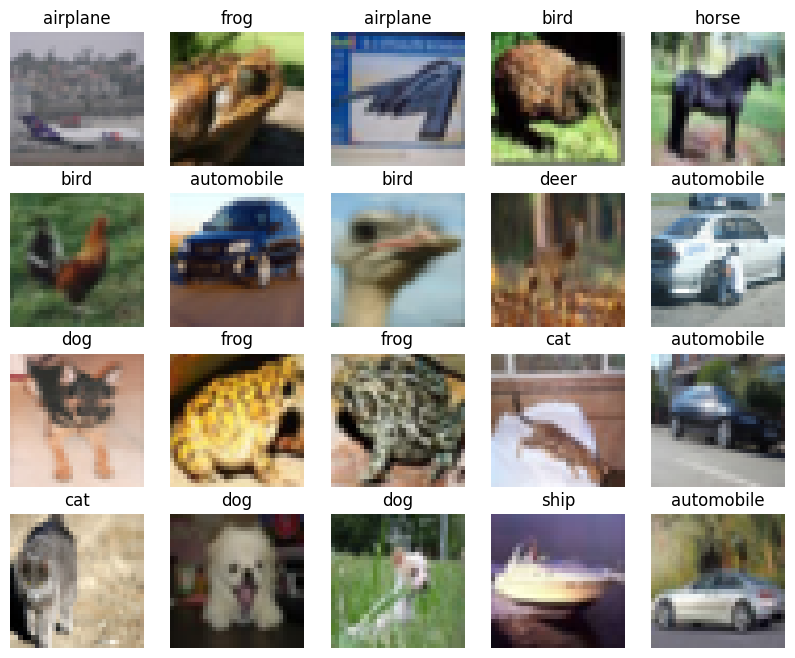

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(4,5,figsize=(10,8))
for i, c in enumerate(t_dataset["train"]):
    x, y = i//5, i%5
    ax[x][y].set_title(classes[t_dataset["train"][i]["label"]])
    ax[x][y].axis('off')
    ax[x][y].imshow(t_dataset["train"][i]["img"])
    if i == 19:
        break

### Sample of Corrupt Dataset

Raw samples from the corrupt dataset

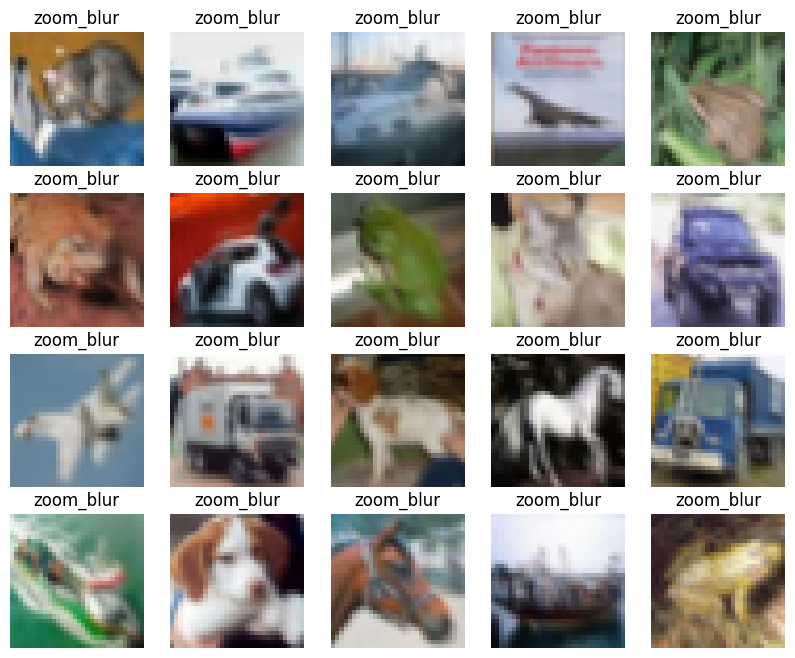

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(4,5,figsize=(10,8))
for i, c in enumerate(c_dataset["train"]):
    x, y = i//5, i%5
    ax[x][y].set_title(c_dataset["train"][i]["corruption_name"])
    ax[x][y].axis('off')
    ax[x][y].imshow(c_dataset["train"][i]["image"])
    if i == 19:
        break

In [10]:
example_label = 7
cd_pf = c_dataset["train"].to_pandas()
unique_c = cd_pf.loc[cd_pf["label"] == example_label].drop_duplicates(subset=["corruption_name"])
print(unique_c.count())
# display(unique_c)

image               19
label               19
corruption_name     19
corruption_level    19
dtype: int64


### Sample of Corruption Types

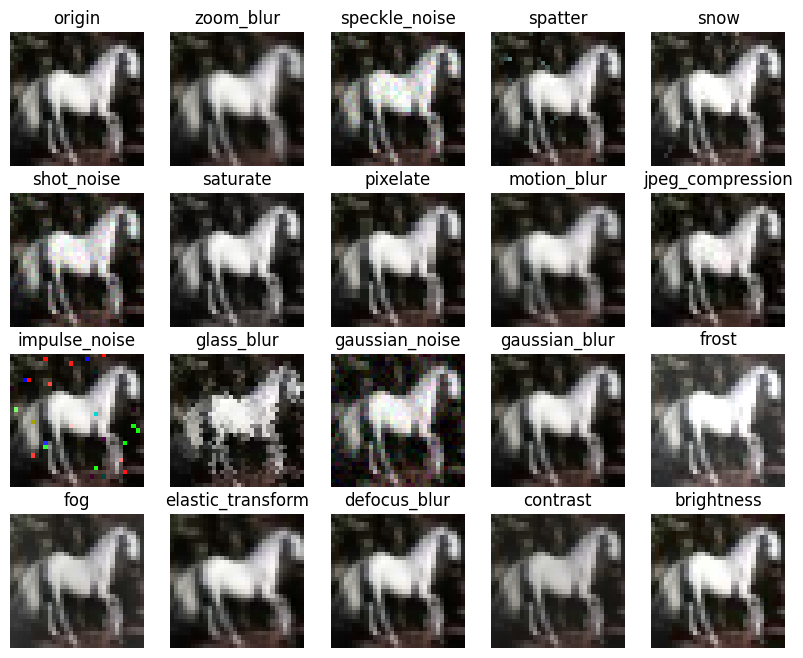

In [ ]:
from PIL import Image
import io
fig, ax = plt.subplots(4,5,figsize=(10,8))

tdf = t_dataset["test"].to_pandas()

img = Image.open(io.BytesIO( tdf[tdf["label"] == example_label].iloc[0]["img"]["bytes"]))
ax[0][0].set_title('origin')
ax[0][0].axis('off')
ax[0][0].imshow(img)
for i in range(len(unique_c)):
    image = Image.open(io.BytesIO(unique_c.iloc[i]["image"]["bytes"]))
    p = i+1
    x, y = p//5, p%5
    ax[x][y].set_title(unique_c.iloc[i]["corruption_name"])
    ax[x][y].axis('off')
    ax[x][y].imshow(image)

----

## Training Configuration

In [12]:
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F

CFG = {
    "classes": classes,
    "batch_size": 256,
    "epochs": 100,
    "lr": 1e-2,
    "weight_decay": 0.0001,
    "use_aug": True,
}
SEED=42
np.random.seed(SEED)


## Dataset Interface

These two functions allow you to get access to the two versions of the data needed to train the two models:
- load_cifar10_m - returns train, valiation, and test for the non-augmented datasets
- load_cifar10_aa - returns train, valiation, and test for the augmented datasets

In [13]:
def load_cifar10_m(batch_size=CFG["batch_size"]):
    """ load normalized cifar10 into memory,
        no data augmentation,
        return three dataloaders,
        train (40000), validation (10000) and test (10000).
    """
    # Shuffle the dataset (See seed above)
    indices = np.arange(len(t_dataset["train"]))
    np.random.shuffle(indices)
    shuffled_train_data = t_dataset["train"].select(indices)
    # Split the dataset
    split_idx = int(0.8 * len(shuffled_train_data))
    train = shuffled_train_data.select(range(split_idx))
    validation = shuffled_train_data.select(range(split_idx, len(shuffled_train_data)))

    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    valid_loader = DataLoader(validation, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(t_dataset["test"], batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    return train_loader, valid_loader, test_loader


def load_cifar10_aa(batch_size=CFG["batch_size"]):
    """ load cifar10 with autoaugmentation """
    t_dataset["train"].reset_format()
    t_dataset["test"].reset_format()
    t_dataset["train"].set_transform(augment_transform_fn)
    t_dataset["test"].set_transform(augment_transform_fn)

     # Shuffle the dataset (See seed above)
    indices = np.arange(len(t_dataset["train"]))
    np.random.shuffle(indices)
    shuffled_train_data = t_dataset["train"].select(indices)
    # Split the dataset
    split_idx = int(0.8 * len(shuffled_train_data))
    train = shuffled_train_data.select(range(split_idx))
    validation = shuffled_train_data.select(range(split_idx, len(shuffled_train_data)))

    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    valid_loader = DataLoader(validation, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(t_dataset["test"], batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    return train_loader, valid_loader, test_loader

# print(load_cifar10_m())
# print(load_cifar10_aa())

# Model Training Code

Functions defined here are for training the model and evaluating the model.

- model_train
- model_eval

In [14]:
import time

def model_train(model, train_loader, val_loader, loss_fn, device,
                lr=CFG["lr"], verbose=False, patience=4, lr_decay=3):
    """ train one model with early stop and learning rate decay,
        after training, model will be updated to the best checkpoint.
    """
    best_loss = 9999
    best_model = None
    counter = 0
    epoch = 0
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []

    learning_rate = lr
    print('learning rate:', learning_rate)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    lr_counter = 0

    model.to(device)
    while True:
        epoch += 1
        tic = time.time()

        model.train()
        train_loss = 0.0
        total = 0
        correct = 0
        for X, Y in train_loader:
            Y = Y.to(device)
            optimizer.zero_grad(set_to_none=True)
            outputs = model(X.to(device))
            loss = loss_fn(outputs, Y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += Y.size(0)
            correct += predicted.eq(Y).sum().item()

        train_loss = train_loss / len(train_loader)
        train_acc = correct / total
        val_loss, val_acc = model_eval(model, val_loader, loss_fn, device)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)

        if best_loss > val_loss:
            best_loss = val_loss
            counter = 0
            best_model = {k:v.detach().cpu() for k,v in model.state_dict().items()}
        else:
            counter += 1

        if verbose:
            toc = time.time()
            print(
                f'Epoch: {epoch} | '
                f'Loss(tr): {train_loss:.8f} | '
                f'Loss(va): {val_loss:.8f} | '
                f'Acc(tr): {train_acc*100:.2f}% | '
                f'Acc(va): {val_acc*100:.2f}% | '
                f'Time: {round(toc-tic,3)}s')

        # if early stop or learning rate decay
        if counter >= patience:
            lr_counter += 1
            if lr_counter >= lr_decay:
                break
            else:
                learning_rate *= 0.1 # weight decay?
                print('learning rate change:', learning_rate)
                optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
                counter = 0

    # update to best model
    if best_model is not None:
        model.load_state_dict({k:v.to(device) for k,v in best_model.items()})

    return train_loss_list, val_loss_list, train_acc_list, val_acc_list

@torch.no_grad()
def model_eval(model, data_loader, loss_fn, device):
    """ evaluate model,
        return loss, accuracy
    """
    model.eval()
    eval_loss = 0.0
    total = 0
    correct = 0
    for X, Y in data_loader:
        Y = Y.to(device)
        outputs = model(X.to(device))
        loss = loss_fn(outputs, Y)
        eval_loss += loss.item()
        _, predicted = outputs.max(1)
        total += Y.size(0)
        correct += predicted.eq(Y).sum().item()
    return eval_loss/len(data_loader), correct/total


----

# Models

In this section we define the models. Currently the ResNet verison is here, but we can either add them all to this notebook or replace this section


In [ ]:
def total_param(model):
    total = 0
    for p in model.parameters():
        try:
            total += p.numel()
        except:
            pass
    return total

## ResNet-8 Model

ResNet-8:

- Input: 32x32 (CIFAR-10)
- Channels: 16 → 32 → 64
- Blocks: 2 per stage (total 6 blocks + initial conv)
- Parameters: ~0.3M–0.7M (can adjust channels to match ViT-Tiny)

There are 3 main components that make up the ResNet.

1. input layer (conv1 + max pooling) (Usually referred to as layer 0)
2. ResBlocks (conv2 without max pooing ~ conv5) (Usually referred to as layer1 ~ layer4)
3. final layer

In [15]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [16]:
class ResNet8(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # Start with 16 channels
        self.in_channels = 16

        # Initial conv layer
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        # Two layers per stage, with channel doubling each stage
        self.layer1 = self._make_layer(16, 2, stride=1)  # 16 channels
        self.layer2 = self._make_layer(32, 2, stride=2)  # 32 channels
        self.layer3 = self._make_layer(64, 2, stride=2)  # 64 channels

        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, out_channels, blocks, stride):
        strides = [stride] + [1] * (blocks - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)  # Global average pool for 32x32 input
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [ ]:
from torchinfo import summary

resnet8 = ResNet8(10).to(device)
summary(resnet8, (1, 3, 32, 32))  # Batch size of 1
total_param(resnet8)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet8                                  [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 32, 32]           432
├─BatchNorm2d: 1-2                       [1, 16, 32, 32]           32
├─Sequential: 1-3                        [1, 16, 32, 32]           --
│    └─BasicBlock: 2-1                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 16, 32, 32]           2,304
│    │    └─BatchNorm2d: 3-2             [1, 16, 32, 32]           32
│    │    └─Conv2d: 3-3                  [1, 16, 32, 32]           2,304
│    │    └─BatchNorm2d: 3-4             [1, 16, 32, 32]           32
│    │    └─Sequential: 3-5              [1, 16, 32, 32]           --
│    └─BasicBlock: 2-2                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-6                  [1, 16, 32, 32]           2,304
│    │    └─BatchNorm2d: 3-7             [1, 16, 32, 32]           32
│    

## Vision Transformer

In [ ]:
class PatchEmbedding(nn.Module):
    """ only for square image,
        each patch is treated as a token.
    """

    def __init__(self, img_size=32, patch_size=8, n_in_channel=3, embed_dim=128):
        super().__init__()
        assert img_size % patch_size == 0
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        # convolution to extract each patch and project to embed_dim
        self.proj = nn.Conv2d(n_in_channel,
                              embed_dim,
                              kernel_size=patch_size,
                              stride=patch_size)

    def forward(self, x):
        # x: (B, C, H, W)
        x = self.proj(x)       # (B, embed_dim, patch_h, patch_w)
        x = x.flatten(2)       # (B, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (B, n_patches, embed_dim)
        return x


class Head(nn.Module):
    """ one head of casual attention (self-attention, no mask) """

    def __init__(self, input_size, head_size):
        super().__init__()
        self.H = head_size
        self.key =   nn.Linear(input_size, head_size, bias=False)
        self.query = nn.Linear(input_size, head_size, bias=False)
        self.value = nn.Linear(input_size, head_size, bias=False)

    def forward(self, x):
        B, T, _ = x.shape # (B, T, input_size)
        k = self.key(x)   # (B, T, head_size)
        q = self.query(x) # (B, T, head_size)
        v = self.value(x) # (B, T, head_size)
        # weight: (B,H,E) @ (B,H,T) -> (B,T,T), scaled down by head size
        w = q @ k.transpose(-2,-1) * (self.H**-0.5)
        w = F.softmax(w, dim=-1)  # (B, T, T)
        # return weighted aggregation of the values
        return w @ v  # (B,T,T) @ (B,T,H) -> (B,T,H)


class MultiHead(nn.Module):
    """ multiple heads of self-attention """

    def __init__(self, input_size, n_head, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(input_size,head_size)
                                         for _ in range(n_head)])

    def forward(self, x):
        return torch.cat([h(x) for h in self.heads], dim=-1)


class FeedFoward(nn.Module):

    def __init__(self, size, n=4):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(size, size*n),
            nn.GELU(),
            nn.Linear(size*n, size),
            nn.Dropout(0.2),
        )

    def forward(self, x):
        return self.layers(x)


class TransBlock(nn.Module):
    """ Transformer Block: Communication and Computation """

    def __init__(self, embed_dim, n_head):
        assert embed_dim % n_head == 0
        super().__init__()
        head_size = embed_dim // n_head
        self.mhsa = MultiHead(embed_dim, n_head, head_size)
        self.ffwd = FeedFoward(embed_dim)
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ln2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # what a single block does:
        x = x + self.mhsa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


class TinyViT(nn.Module):

    def __init__(self,
                 img_size=32,
                 patch_size=4,
                 n_in_channel=3,
                 n_class=10,
                 embed_dim=128,
                 n_head=4,
                 n_depth=4):
        super().__init__()

        # 2 embeddings and 1 class token:
        # patch (token), position

        # patch embedding
        self.patch_embed = PatchEmbedding(img_size, patch_size, n_in_channel, embed_dim)
        n_patches = self.patch_embed.n_patches

        # class token and positional embedding
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        # +1: give class token a position
        self.pos_embed = nn.Parameter(torch.zeros(1, n_patches + 1, embed_dim))
        # init
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

        # transformer blocks
        self.blocks = nn.ModuleList([TransBlock(embed_dim,n_head) for _ in range(n_depth)])

        # classification head
        self.ln = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, n_class)

    def forward(self, x):
        B = x.shape[0]

        # patch embedding
        x = self.patch_embed(x)  # (B, n_patch, embed_dim)

        # add class token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)

        # add positional embedding
        x = x + self.pos_embed

        # transformer blocks
        for block in self.blocks:
            x = block(x)

        # classification
        x = self.ln(x)
        cls_token_final = x[:, 0]
        return self.head(cls_token_final)

In [ ]:
from functools import lru_cache, partial
model_class = partial(TinyViT, img_size=32,
                               patch_size=4,
                               embed_dim=64,
                               n_depth=2,
                               n_head=2,
                               n_class=10)
model = model_class()
# test with dummy input
x = torch.randn(256, 3, 32, 32)
output = model(x)
print(f"Output Shape: {output.shape}")
assert output.shape == (256,10)
# count parameters
print(f"Total Parameters: {total_param(model):,}")

----

# Train Models

## Train ResNet-8

In [18]:
model_res_base = ResNet8(len(CFG["classes"])).to(device)
model_res_augm = ResNet8(len(CFG["classes"])).to(device)

# Should this just be in train?
loss = nn.CrossEntropyLoss()

train, val, test = load_cifar10_m()
model_res_base_df = pd.DataFrame(data=model_train(model_res_base, train, val, loss, device)).T
model_res_base_df.columns = ['train_loss', 'val_loss', 'train_acc', 'val_acc']
# Save the output so we can compare the output easier
model_res_base_df.to_csv("resnet8_train_base.csv")
# display(model_res_base_df.head())

train, val, test = load_cifar10_aa()
model_res_augm_df = pd.DataFrame(data=model_train(model_res_augm, train, val, loss, device)).T
model_res_augm_df.columns = ['train_loss', 'val_loss', 'train_acc', 'val_acc']
# Save the output so we can compare the output easier
model_res_augm_df.to_csv("resnet8_train_augm.csv")
# display(model_res_augm_df.head())


learning rate: 0.01
learning rate change: 0.001
learning rate change: 0.0001
learning rate: 0.01
learning rate change: 0.001
learning rate change: 0.0001


# Analyze

In [19]:
def plot_results(df, title="ResNet8 on CIFAR10"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(title)
    ax[0].set_xlabel('epochs')
    ax[0].plot(df["train_loss"], label='train loss')
    ax[0].plot(df["val_loss"], label='val loss')
    ax[0].legend()
    ax[1].set_xlabel('epochs')
    ax[1].plot(df["train_acc"], label='train accuracy')
    ax[1].plot(df["val_acc"], label='val accuracy')
    ax[1].legend()
    plt.show()


## Resnet 8

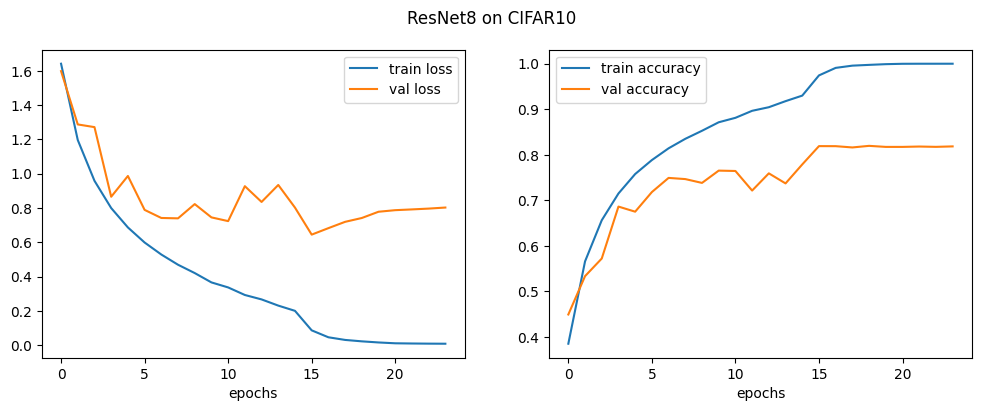

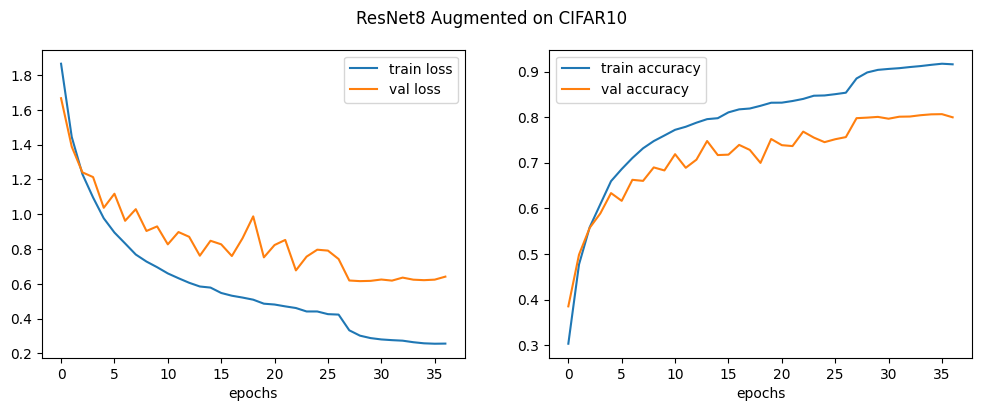

In [20]:
plot_results(model_res_base_df, "ResNet8 on CIFAR10")
plot_results(model_res_augm_df, "ResNet8 Augmented on CIFAR10")

In [21]:
# robust_loader = DataLoader(r_dataset, batch_size=CFG["batch_size"], shuffle=False, collate_fn=collate_fn)
# total_params = np.array([p.numel() for p in model.parameters()]).sum()

# robust_loss, robust_acc = model_eval(model, robust_loader, loss, device)

# print('robust loss:', robust_loss)
# print('robust accuracy:', robust_acc)
# print('parameter efficiency:', robust_acc / total_params)

# Robustness (Natural Corruptions)

In [ ]:
# tdata = [('corruption','severity', 'loss_a', 'loss_b', 'accuracy_a', 'accuracy_b', 'b-a')]
# labels = torch.from_numpy(corruptions)

# for corruption in tqdm(corruptions):
#     acclist_a = []
#     acclist_b = []

#     for i in range(1, 6):
#         x_test = load_cifar10c(corruption, i)
#         x_test = cifar10c_norm(x_test)

#         test_loader = DataLoader(TensorDataset(x_test, labels), batch_size=256, shuffle=False)

#         loss_a, acc_a = model_eval(model_a, test_loader, DEV)
#         loss_b, acc_b = model_eval(model_b, test_loader, DEV)

#         tdata.append((corruption, i, loss_a, loss_b, acc_a, acc_b, acc_b-acc_a))
#         acclist_a.append(acc_a)
#         acclist_b.append(acc_b)

#     tdata.append(('-','-',0.0,0.0,
#                   min(acclist_a) - max(acclist_a),
#                   min(acclist_b) - max(acclist_b)))